# Fully Bayesian Multi-Objective Optimization using qNEHVI + SAASBO

### This Tutorial

This tutorial will show how to use qNEHVI with fully bayesian inference for multi-objective 
optimization.

Multi-objective optimization (MOO) covers the case where we care about multiple
outcomes in our experiment but we do not know before hand a specific weighting of those
objectives (covered by `ScalarizedObjective`) or a specific constraint on one objective 
(covered by `OutcomeConstraint`s) that will produce the best result.

The solution in this case is to find a whole Pareto frontier, a surface in outcome-space
containing points that can't be improved on in every outcome. This shows us the
tradeoffs between objectives that we can choose to make.

### Problem Statement

Optimize a list of M objective functions $ \bigl(f^{(1)}( x),..., f^{(M)}( x) \bigr)$ over a bounded search space $\mathcal X \subset \mathbb R^d$.

We assume $f^{(i)}$ are expensive-to-evaluate black-box functions with no known analytical expression, and no observed gradients. For instance, a machine learning model where we're interested in maximizing accuracy and minimizing inference time, with $\mathcal X$ the set of possible configuration spaces

### Fully Bayesian Inference

Previous work, has shown that using a fully Bayesian treatment of GP model hyperparameters $\boldsymbol \theta$ can lead to improved closed loop Bayesian optimization performance [1]. Snoek et al [1] propose to use an integrated acquisition function $\alpha_{MCMC}$ where the base acquisition function $\alpha(\mathbf{x} | \boldsymbol \theta, \mathcal D)$ is integrated over the the posterior distribution over the hyperparameters $p({\boldsymbol{\theta}} | \mathcal{D})$, where $ \mathcal{D} = \{{\mathbf{x}}_i, y_i\}_{i=1}^n$:

$\alpha_{MCMC}(\mathbf{x}, \mathcal D) = \int \alpha(\mathbf{x} | \boldsymbol \theta, \mathcal D) p(\boldsymbol \theta | \mathcal D) d\boldsymbol \theta$


Since  $p({\boldsymbol{\theta}} | \mathcal{D})$ typically cannot be expressed in closed-form, Markov Chain Monte-Carlo (MCMC) methods are used to draw samples from $p({\boldsymbol{\theta}} | \mathcal{D})$. In this tutorial we use the NUTS sampler from the pyro package for automatic, robust fully Bayesian inference.

[1] J. Snoek, H. Larochelle, R. P. Adams, Practical Bayesian Optimization of Machine Learning Algorithms. Advances in Neural Information Processing Systems 26, 2012.

### SAAS Priors (SAASBO)

Recently Eriksson et al [2] propose using sparse axis-aligned subspace priors for Bayesian optimization over high-dimensional search spaces. Specifically, the authors propose using a hierarchical sparsity prior consisting of a global shrinkage parameter with a Half-Cauchy prior $\tau \sim \mathcal{HC}(\beta)$, and ARD lengthscales $\rho_d \sim \mathcal{HC}(\tau)$ for $d=1, ..., D$. See [2] for details. 

[2] D. Eriksson, M. Jankowiak. High-Dimensional Bayesian Optimization with Sparse Axis-Aligned Subspaces. Proceedings of the Thirty-Seventh Conference on Uncertainty in Artificial Intelligence, 2021.

### qNEHVI 

In this tutorial, we use qNEHVI [3] as our acquisition function for multi-objective optimization. We integrate qNEHVI over the posterior distribution of the GP hyperparameters as proposed in [4].

[3] S. Daulton, M. Balandat, E. Bakshy. Parallel Bayesian Optimization of Multiple Noisy Objectives with Expected Hypervolume Improvement. Arxiv, 2021.

[4] D. Eriksson, P. Chuang, S. Daulton, P. Xia, A. Shrivastava, A. Babu, S. Zhao, A. Aly, G. Venkatesh, M. Balandat. Latency-Aware Neural Architecture Search with Multi-Objective Bayesian Optimization. ICML AutoML Workshop, 2021.

### Further Information

For a deeper explanation of multi-objective optimization, please refer to the dedicated multi-objective optimization tutorial: https://ax.dev/tutorials/multiobjective_optimization.html.

## Setup

In this tutorial, we use Ax Developer API. Additional resources:
- To learn more about the developer API, refer to the dedicated tutorial: https://ax.dev/tutorials/gpei_hartmann_developer.html. 
- To set up a `GenerationStrategy` with multi-objective SAASBO (and use it in Ax Service API), follow the generation strategy tutorial: https://ax.dev/tutorials/generation_strategy.html and use `Models.SAASBO` for the Bayesian optimization generation step.
- To learn about multi-objective optimization in Ax Service API: https://ax.dev/tutorials/multiobjective_optimization.html#Using-the-Service-API.

In [1]:
import os

import matplotlib

import numpy as np

import pandas as pd
import torch
from ax.core.data import Data
from ax.core.experiment import Experiment
from ax.core.metric import Metric
from ax.core.objective import MultiObjective, Objective
from ax.core.optimization_config import (
    MultiObjectiveOptimizationConfig,
    ObjectiveThreshold,
)
from ax.core.parameter import ParameterType, RangeParameter
from ax.core.search_space import SearchSpace
from ax.metrics.noisy_function import GenericNoisyFunctionMetric
from ax.modelbridge.cross_validation import compute_diagnostics, cross_validate

# Analysis utilities, including a method to evaluate hypervolumes
from ax.modelbridge.modelbridge_utils import observed_hypervolume

# Model registry for creating multi-objective optimization models.
from ax.modelbridge.registry import Models
from ax.models.torch.botorch_modular.surrogate import Surrogate
from ax.plot.contour import plot_contour
from ax.plot.diagnostic import tile_cross_validation
from ax.plot.pareto_frontier import plot_pareto_frontier
from ax.plot.pareto_utils import compute_posterior_pareto_frontier
from ax.runners.synthetic import SyntheticRunner
from ax.service.utils.report_utils import exp_to_df

# Plotting imports and initialization
from ax.utils.notebook.plotting import init_notebook_plotting, render
from botorch.models.fully_bayesian import SaasFullyBayesianSingleTaskGP
from botorch.test_functions.multi_objective import DTLZ2
from botorch.utils.multi_objective.box_decompositions.dominated import (
    DominatedPartitioning,
)
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable

In [2]:
init_notebook_plotting()

[INFO 12-09 19:22:25] ax.utils.notebook.plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.


[INFO 12-09 19:22:25] ax.utils.notebook.plotting: Please see
    (https://ax.dev/tutorials/visualizations.html#Fix-for-plots-that-are-not-rendering)
    if visualizations are not rendering.


In [3]:
SMOKE_TEST = os.environ.get("SMOKE_TEST")

### Load our sample 2-objective problem

In [4]:
d = 10
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
problem = DTLZ2(num_objectives=2, dim=d, negate=True).to(**tkwargs)

## Define experiment configurations

### Search Space

In [5]:
search_space = SearchSpace(
    parameters=[
        RangeParameter(
            name=f"x{i}", lower=0, upper=1, parameter_type=ParameterType.FLOAT
        )
        for i in range(d)
    ],
)

### MultiObjectiveOptimizationConfig

To optimize multiple objective we must create a `MultiObjective` containing the metrics we'll optimize and `MultiObjectiveOptimizationConfig` (which contains `ObjectiveThreshold`s) instead of our more typical `Objective` and `OptimizationConfig`. Additional resources:
- To set up a custom metric for your problem, refer to the dedicated section of the Developer API tutorial: https://ax.dev/tutorials/gpei_hartmann_developer.html#8.-Defining-custom-metrics.
- To avoid needing to setup up custom metrics by using multi-objective optimization in Ax Service API: https://ax.dev/tutorials/multiobjective_optimization.html#Using-the-Service-API.

We define `GenericNoisyFunctionMetric`s to wrap our synthetic Branin-Currin problem's outputs.

In [6]:
param_names = [f"x{i}" for i in range(d)]

In [7]:
def f1(x) -> float:
    x_sorted = [x[p_name] for p_name in param_names]
    return float(problem(torch.tensor(x_sorted, **tkwargs).clamp(0.0, 1.0))[0])


def f2(x) -> float:
    x_sorted = [x[p_name] for p_name in param_names]
    return float(problem(torch.tensor(x_sorted, **tkwargs).clamp(0.0, 1.0))[1])


metric_a = GenericNoisyFunctionMetric("a", f=f1, noise_sd=0.0, lower_is_better=False)
metric_b = GenericNoisyFunctionMetric("b", f=f2, noise_sd=0.0, lower_is_better=False)

In [8]:
mo = MultiObjective(
    objectives=[Objective(metric=metric_a), Objective(metric=metric_b)],
)

In [9]:
objective_thresholds = [
    ObjectiveThreshold(metric=metric, bound=val, relative=False)
    for metric, val in zip(mo.metrics, problem.ref_point)
]

In [10]:
optimization_config = MultiObjectiveOptimizationConfig(
    objective=mo,
    objective_thresholds=objective_thresholds,
)

## Define experiment creation utilities

These construct our experiment, then initialize with Sobol points before we fit a Gaussian Process model to those initial points.

In [11]:
N_INIT = 2 * (d + 1)

In [12]:
def build_experiment():
    experiment = Experiment(
        name="pareto_experiment",
        search_space=search_space,
        optimization_config=optimization_config,
        runner=SyntheticRunner(),
    )
    return experiment

In [13]:
def initialize_experiment(experiment):
    sobol = Models.SOBOL(search_space=experiment.search_space)
    experiment.new_batch_trial(sobol.gen(N_INIT)).run()
    return experiment.fetch_data()

## qNEHVI + SAASBO
Noisy expected hypervolume improvement + fully Bayesian inference with SAAS priors.

In [14]:
experiment = build_experiment()
data = initialize_experiment(experiment)

In [15]:
BATCH_SIZE = 4

if SMOKE_TEST:
    N_BATCH = 1
    num_samples = 128
    warmup_steps = 256
else:
    N_BATCH = 10
    BATCH_SIZE = 4
    num_samples = 256
    warmup_steps = 512

In [16]:
hv_list = []
model = None
for i in range(N_BATCH):
    model = Models.BOTORCH_MODULAR(
        experiment=experiment,
        data=data,
        surrogate=Surrogate(
            botorch_model_class=SaasFullyBayesianSingleTaskGP,
            mll_options={
                "num_samples": num_samples,  # Increasing this may result in better model fits
                "warmup_steps": warmup_steps,  # Increasing this may result in better model fits
            },
        )
        )
    generator_run = model.gen(BATCH_SIZE)
    trial = experiment.new_batch_trial(generator_run=generator_run)
    trial.run()
    data = Data.from_multiple_data([data, trial.fetch_data()])

    exp_df = exp_to_df(experiment)
    outcomes = torch.tensor(exp_df[["a", "b"]].values, **tkwargs)
    partitioning = DominatedPartitioning(ref_point=problem.ref_point, Y=outcomes)
    try:
        hv = partitioning.compute_hypervolume().item()
    except:
        hv = 0
        print("Failed to compute hv")
    hv_list.append(hv)
    print(f"Iteration: {i}, HV: {hv}")

df = exp_to_df(experiment).sort_values(by=["trial_index"])
outcomes = df[["a", "b"]].values

[WARNING 12-09 19:23:56] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 0, HV: 0.0


[WARNING 12-09 19:26:13] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 1, HV: 0.0


[WARNING 12-09 19:28:12] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 2, HV: 0.0


[WARNING 12-09 19:30:15] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 3, HV: 0.0


[WARNING 12-09 19:32:19] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 4, HV: 0.0


[WARNING 12-09 19:34:42] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 5, HV: 0.0


[WARNING 12-09 19:37:23] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 6, HV: 0.0


[WARNING 12-09 19:40:09] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 7, HV: 0.174672386011633


[WARNING 12-09 19:42:47] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 8, HV: 0.2404343440112483


[WARNING 12-09 19:45:58] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


[WARNING 12-09 19:45:58] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 9, HV: 0.27309460991360907


## Plot empirical data

#### Plot observed hypervolume, with color representing the iteration that a point was generated on.

Text(0.5, 1.0, 'Iteration')

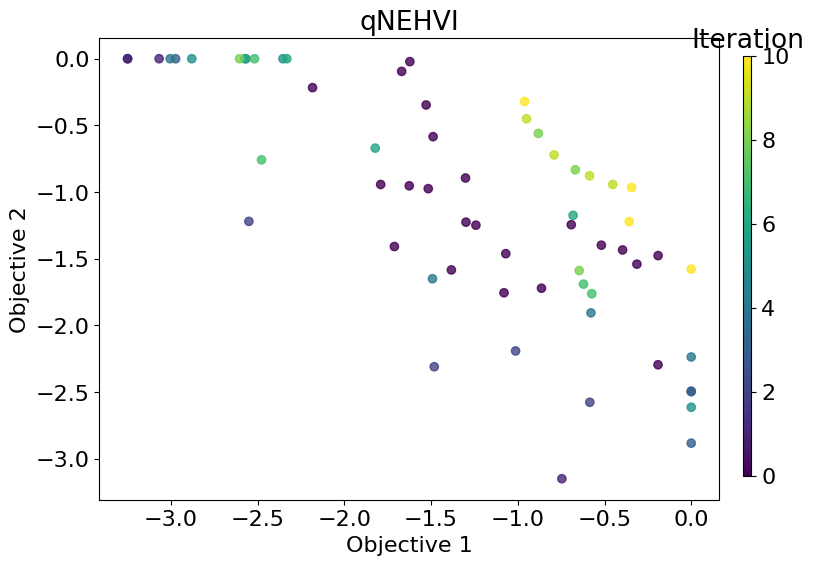

In [17]:
%matplotlib inline
matplotlib.rcParams.update({"font.size": 16})


fig, axes = plt.subplots(1, 1, figsize=(8, 6))
algos = ["qNEHVI"]
train_obj = outcomes
cm = matplotlib.colormaps["viridis"]

n_results = N_INIT + N_BATCH * BATCH_SIZE

batch_number = df.trial_index.values
sc = axes.scatter(train_obj[:, 0], train_obj[:, 1], c=batch_number, alpha=0.8)
axes.set_title(algos[0])
axes.set_xlabel("Objective 1")
axes.set_ylabel("Objective 2")
norm = plt.Normalize(batch_number.min(), batch_number.max())
sm = ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration")

# Hypervolume statistics
The hypervolume of the space dominated by points that dominate the reference point.

#### Plot the results
The plot below shows a common metric of multi-objective optimization performance when the true Pareto frontier is known:  the log difference between the hypervolume of the true Pareto front and the hypervolume of the approximate Pareto front identified by qNEHVI.

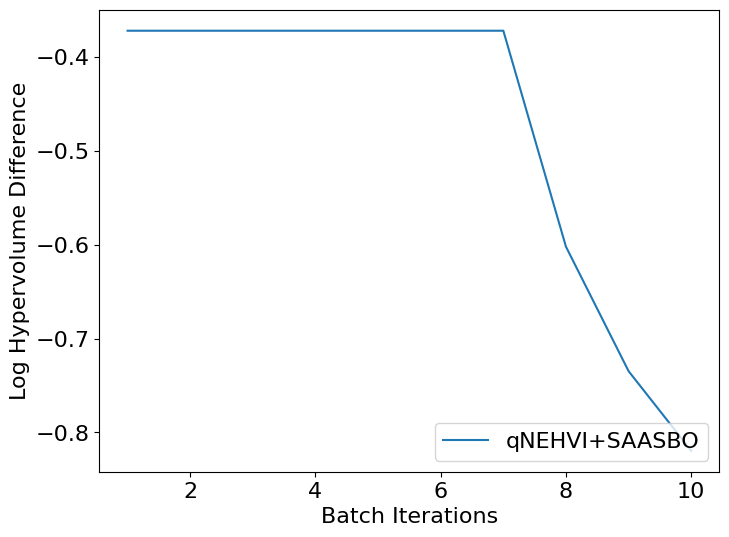

In [18]:
iters = np.arange(1, N_BATCH + 1)
log_hv_difference = np.log10(problem.max_hv - np.asarray(hv_list))[: N_BATCH + 1]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(iters, log_hv_difference, label="qNEHVI+SAASBO", linewidth=1.5)
ax.set(xlabel="Batch Iterations", ylabel="Log Hypervolume Difference")
ax.legend(loc="lower right")

## Inspect Model fits

Here, we examine the GP model fits using the fully bayesian inference with SAAS priors. We plot the leave-one-out cross-validation below. Note: model hyperparameters are not re-sampled on each fold to reduce the runtime.

In [19]:
saas_model = Models.SAASBO(experiment=experiment, data=data)
cv = cross_validate(model)
render(tile_cross_validation(cv))

In [20]:
# compute  out-of-sample log likelihood
compute_diagnostics(cv)["Log likelihood"]

/tmp/tmp.bwZKabbZig/Ax-main/ax/utils/stats/model_fit_stats.py:133: RuntimeWarning:

divide by zero encountered in divide



{'a': 20.189962035208993, 'b': 14.437898772056819}

Finally, we examine the GP model fits using MAP estimation for comparison. The fully bayesian model has a higher log-likelihood than the MAP model. 

In [21]:
map_model = Models.BOTORCH_MODULAR(experiment=experiment, data=data)
map_cv = cross_validate(map_model)
render(tile_cross_validation(map_cv))

In [22]:
# compute out-of-sample log likelihood
compute_diagnostics(map_cv)["Log likelihood"]

/tmp/tmp.bwZKabbZig/Ax-main/ax/utils/stats/model_fit_stats.py:133: RuntimeWarning:

divide by zero encountered in divide



{'a': -11.115359597512933, 'b': -14.750603795963471}